## Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from tqdm import tqdm
import glob
import os
from time import sleep
import fnmatch


## Load clean data

In [2]:
fomc_rates = pd.read_csv('inputs/Clean_Data/Clean_Rates.csv')
sp500_ret = pd.read_csv('inputs/Clean_Data/Clean_sp500_ret.csv')
stock_tv = pd.read_csv('inputs/Clean_Data/Clean_stock_tv.csv')
Vbilx = pd.read_csv('inputs/Clean_Data/Clean_Vbilx.csv')
Vbirx= pd.read_csv('inputs/Clean_Data/Clean_Vbirx.csv')

## Assemble Data Frames

In [3]:
sp500_ret = sp500_ret.rename(columns = {'date': 'Date','Daily Returns' : 'SP_daily_ret', 'Price': 'SP_daily_price' })

In [4]:
Vbirx
Vbirx = Vbirx.rename(columns = {'Daily Returns' : 'VBIRX_daily_ret', 'Price': 'VBIRX_daily_price' })
Vbirx = Vbirx.rename(columns = {'Daily Price': 'VBIRX_daily_price' })
Vbirx

,VBIRX_daily_ret,VBIRX_daily_price,Date
0,0.000000,9.148480,2015-01-02
1,0.000954,9.157207,2015-01-05
2,0.000953,9.165930,2015-01-06
3,0.000951,9.174648,2015-01-07
4,-0.000950,9.165930,2015-01-08
...,...,...,...
2086,0.000000,9.990000,2023-04-18
2087,-0.001001,9.980000,2023-04-19
2088,0.002004,10.000000,2023-04-20
2089,0.000000,10.000000,2023-04-21


In [5]:
Vbilx = Vbilx.rename(columns = {'Daily Price': 'VBILX_daily_price', 'Daily Returns' : 'VBLIX_daily_ret' })
Vbilx

,VBLIX_daily_ret,VBILX_daily_price,Date
0,0.004348,9.135244,2015-01-05
1,0.004329,9.174787,2015-01-06
2,0.000000,9.174787,2015-01-07
3,-0.002586,9.151057,2015-01-08
4,0.003458,9.182699,2015-01-09
...,...,...,...
2085,0.001938,10.340000,2023-04-18
2086,-0.001934,10.320000,2023-04-19
2087,0.003876,10.360000,2023-04-20
2088,-0.001930,10.340000,2023-04-21


In [6]:
sp500_ret = sp500_ret.rename(columns = {'returns' : 'sp500_ret'})
sp500_ret

,Date,S&P_500,sp500_ret
0,2015-01-05,2020.58,-0.018278
1,2015-01-06,2002.61,-0.008893
2,2015-01-07,2025.90,0.011630
3,2015-01-08,2062.14,0.017888
4,2015-01-09,2044.81,-0.008404
...,...,...,...
2085,2023-04-18,4154.87,0.000855
2086,2023-04-19,4154.52,-0.000084
2087,2023-04-20,4129.79,-0.005953
2088,2023-04-21,4133.52,0.000903


In [7]:
stock_tv
stock_tv.drop_duplicates(inplace=True)
stock_tv = stock_tv.rename(columns = {'Value' : 'sp500_tv'})
stock_tv

,Date,sp500_tv
0,12/2/15,1088000.0
1,12/3/15,1379000.0
2,12/4/15,1308000.0
3,12/7/15,712744.0
4,12/8/15,670998.0
...,...,...
489,3/31/23,3293000.0
490,4/3/23,2494000.0
491,4/4/23,2687000.0
492,4/5/23,2311000.0


In [8]:
final_data = sp500_ret.merge(Vbilx, 
              on=['Date'],
              how='left',
              validate='one_to_one') # or 'many_to_one'

In [9]:
final_data2 = final_data.merge(Vbirx, on=['Date'],
              how='left',
              validate='one_to_one')

### Create Dummy Variable

In [10]:
fomc_rates 
fomc_rates['Change'] = np.where(fomc_rates['Increase'] > 0,1,0)
fomc_rates

,Date,Increase,Decrease,Tgt_level,Change
0,2015-12-17,25.0,0.0,0.25.0.50,1
1,2016-12-15,25.0,0.0,0.50.0.75,1
2,2017-03-16,25.0,0.0,0.75.1.00,1
3,2017-06-15,25.0,0.0,1.00.1.25,1
4,2017-12-14,25.0,0.0,1.25.1.50,1
5,2018-03-22,25.0,0.0,1.50.1.75,1
6,2018-06-14,25.0,0.0,1.75.2.00,1
7,2018-09-27,25.0,0.0,2.00.2.25,1
8,2018-12-20,25.0,0.0,2.25.2.50,1
9,2019-08-01,0.0,25.0,2.00.2.25,0


**Dummy variable equals 1 when the rate increases, 0 if it was decreased.

In [11]:
#master_df = final_data2.merge(fomc_rates, on = ["Date"], how = 'left', 
 #                     validate = 'm:1', indicator = True)

### Create Event Time Variable

In [12]:
pd.set_option('display.max_rows',70)


In [13]:
fomc_rates

,Date,Increase,Decrease,Tgt_level,Change
0,2015-12-17,25.0,0.0,0.25.0.50,1
1,2016-12-15,25.0,0.0,0.50.0.75,1
2,2017-03-16,25.0,0.0,0.75.1.00,1
3,2017-06-15,25.0,0.0,1.00.1.25,1
4,2017-12-14,25.0,0.0,1.25.1.50,1
5,2018-03-22,25.0,0.0,1.50.1.75,1
6,2018-06-14,25.0,0.0,1.75.2.00,1
7,2018-09-27,25.0,0.0,2.00.2.25,1
8,2018-12-20,25.0,0.0,2.25.2.50,1
9,2019-08-01,0.0,25.0,2.00.2.25,0


In [14]:
event_time_rets = (
    final_data2.merge(fomc_rates[['Date']], on = ["Date"], how = 'left', 
                      validate = 'm:1', indicator = True)
    
    # create event flag, then use this to create event_id
    .assign(event = lambda x: (x['_merge'] == 'both').astype(int))    
    .assign(event_id = lambda x: x['event'].cumsum(),
            date2 = lambda x: x['Date'])
    
    # reduce dataframe to [-10,+10] around event
    # event id starts 10 days before event and goes to 10 days after
    .assign(event_id = lambda x: x['event_id'].shift(-10))
    .query('event_id > 0')
    .groupby('event_id').head(20)
    
    # helper columns
    .assign(increment =lambda x: np.arange(len(x)),
            inc_at_e = lambda x: x['event']*x['increment'])
    
    #inc_at_e alwasy equal to increment # at firms event
    .assign(inc_at_e = lambda x: x.groupby('event_id')['inc_at_e'].transform(sum))
    
    #compute event time
    .assign(event_time = lambda x: x['increment'] -x['inc_at_e'])
   
    # clear out useless columns
    .drop(['_merge','date2','increment','inc_at_e'],axis=1)
)

In [15]:
# we need a new var = the date of the event so that we can merge in fomc_rate vars

# Create a new column 'date_when_var2_is_1' and set it to NaN initially
event_time_rets['event_id_date'] = np.nan

# Find the date from 'var1' when 'var2' is equal to 1 for each 'event_id'
date_when_var2_is_1 = event_time_rets[event_time_rets['event'] == 1].groupby('event_id')['Date'].first()

# Iterate through the unique event_ids and set the 'date_when_var2_is_1' value for each event_id
for event_id, date_value in date_when_var2_is_1.items():
    event_time_rets.loc[event_time_rets['event_id'] == event_id, 'event_id_date'] = date_value
    

In [16]:
# now merge in fomc_rate date
event_time_rets = event_time_rets.merge(fomc_rates,
                      left_on = 'event_id_date',
                      right_on = 'Date',
                      how = 'left',
                      validate = 'm:1').drop('Date_y',axis=1)

In [17]:
event_time_rets

,Date_x,S&P_500,sp500_ret,VBLIX_daily_ret,VBILX_daily_price,VBIRX_daily_ret,VBIRX_daily_price,event,event_id,event_time,event_id_date,Increase,Decrease,Tgt_level,Change
0,2015-12-03,2049.62,-0.014374,-0.007888,9.178914,-0.001908,9.234923,0,1.0,-10,2015-12-17,25.0,0.0,0.25.0.50,1.0
1,2015-12-04,2091.69,0.020526,0.001767,9.195133,0.000000,9.234923,0,1.0,-9,2015-12-17,25.0,0.0,0.25.0.50,1.0
2,2015-12-07,2077.07,-0.006990,0.002645,9.219457,0.000956,9.243752,0,1.0,-8,2015-12-17,25.0,0.0,0.25.0.50,1.0
3,2015-12-08,2063.59,-0.006490,0.000000,9.219457,0.000000,9.243752,0,1.0,-7,2015-12-17,25.0,0.0,0.25.0.50,1.0
4,2015-12-09,2047.62,-0.007739,0.000880,9.227571,0.000000,9.243752,0,1.0,-6,2015-12-17,25.0,0.0,0.25.0.50,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,2023-03-30,4050.83,0.005715,0.001942,10.320000,0.000000,9.980000,0,23.0,5,2023-03-23,25.0,0.0,4.75.5.00,1.0
445,2023-03-31,4109.31,0.014437,0.004845,10.370000,0.003006,10.010000,0,23.0,6,2023-03-23,25.0,0.0,4.75.5.00,1.0
446,2023-04-03,4124.51,0.003699,0.004822,10.420000,0.001998,10.030000,0,23.0,7,2023-03-23,25.0,0.0,4.75.5.00,1.0
447,2023-04-04,4100.60,-0.005797,0.004798,10.470000,0.002991,10.060000,0,23.0,8,2023-03-23,25.0,0.0,4.75.5.00,1.0


### Correlation Matrix

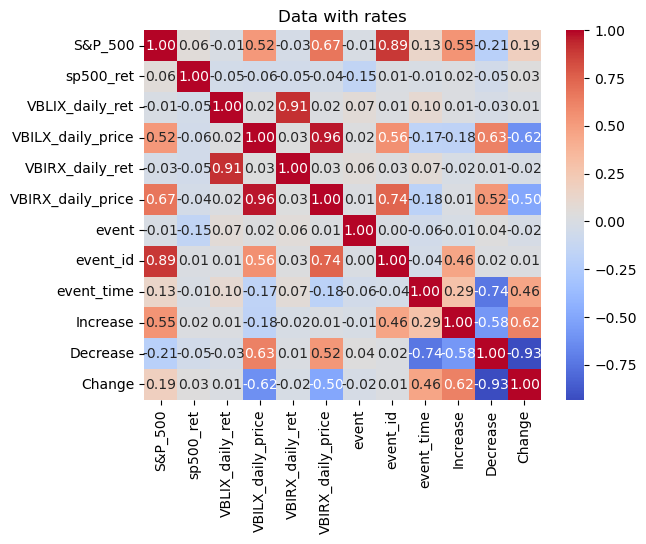

In [18]:
corr_matrix = event_time_rets.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Data with rates')
plt.show()

### Scatter Plots

# Event Time Study Figures

### S&P 500

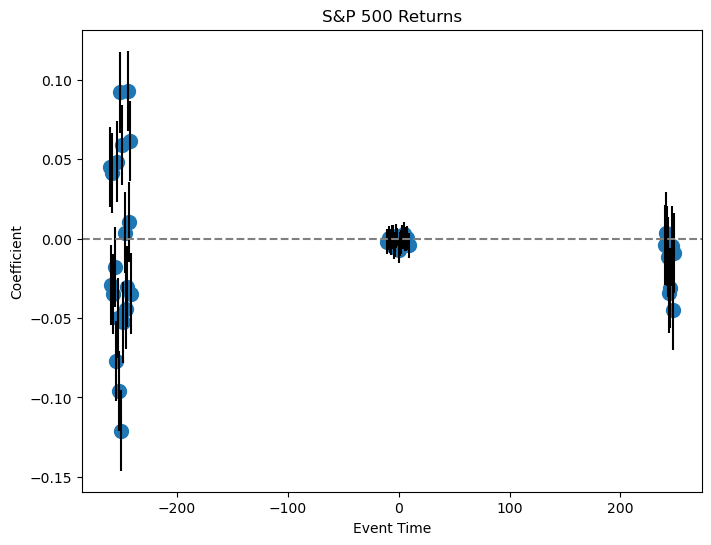

In [19]:
# run the regression
model   = smf.ols(formula='sp500_ret ~ C(event_time,Treatment(reference=-1))', data=event_time_rets)
results = model.fit()


# extract the coefficients and confidence intervals
fig, ax            = plt.subplots(figsize=(8, 6))
coef_table         = results.conf_int(alpha=0.05)
coef_table['coef'] = results.params
coef_table.columns = ['lower', 'upper', 'coef']

# the reg table's categorical names stink: C(event_time, Treatment(reference=-1))[T.-4]
# lets rename them to the right level
def categorical_relabel(varname,reference_label):
    try:
        return int(varname.split('[T.')[1].split(']')[0])
    except:
        return reference_label
   
coef_table['event_time'] = coef_table.index.map(lambda x: categorical_relabel(x, -1))

# plot
coef_table.plot(kind='scatter', x='event_time', y='coef', ax=ax, s=100)
ax.errorbar(coef_table['event_time'], coef_table['coef'], yerr=[coef_table['coef'] - coef_table['lower'], coef_table['upper'] - coef_table['coef']], fmt='none', color='black')
plt.title('S&P 500 Returns')
plt.xlabel('Event Time')
plt.ylabel('Coefficient')
ax.axhline(y=0, color='gray', linestyle='--')
plt.show()

### VBILX

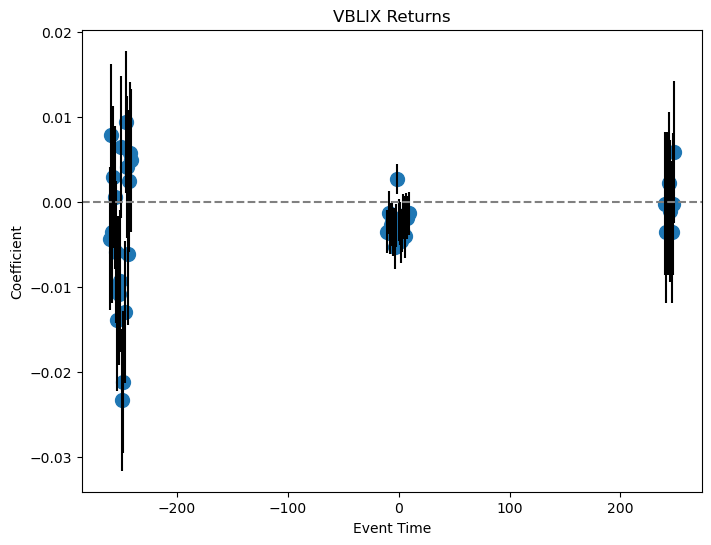

In [20]:
# run the regression
model   = smf.ols(formula='VBLIX_daily_ret ~ C(event_time,Treatment(reference=-1))', data=event_time_rets)
results = model.fit()


# extract the coefficients and confidence intervals
fig, ax            = plt.subplots(figsize=(8, 6))
coef_table         = results.conf_int(alpha=0.05)
coef_table['coef'] = results.params
coef_table.columns = ['lower', 'upper', 'coef']

# the reg table's categorical names stink: C(event_time, Treatment(reference=-1))[T.-4]
# lets rename them to the right level
def categorical_relabel(varname,reference_label):
    try:
        return int(varname.split('[T.')[1].split(']')[0])
    except:
        return reference_label
   
coef_table['event_time'] = coef_table.index.map(lambda x: categorical_relabel(x, -1))

# plot
coef_table.plot(kind='scatter', x='event_time', y='coef', ax=ax, s=100)
ax.errorbar(coef_table['event_time'], coef_table['coef'], yerr=[coef_table['coef'] - coef_table['lower'], coef_table['upper'] - coef_table['coef']], fmt='none', color='black')
plt.title('VBLIX Returns')
plt.xlabel('Event Time')
plt.ylabel('Coefficient')
ax.axhline(y=0, color='gray', linestyle='--')
plt.show()

### VBIRX

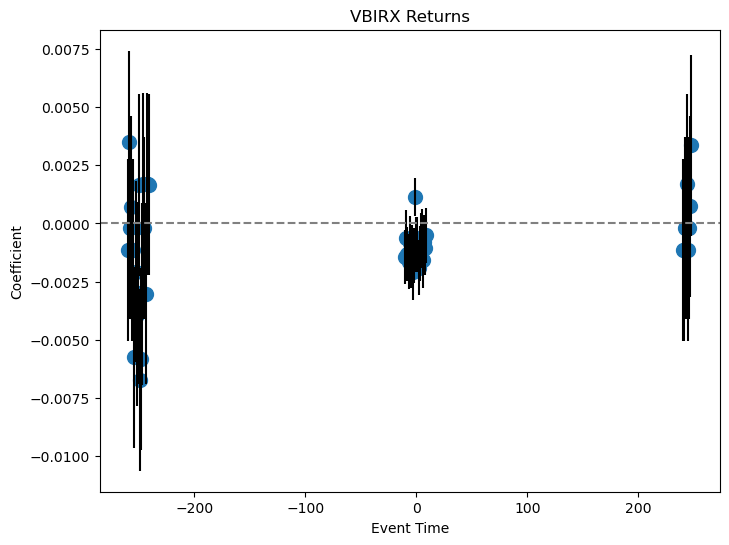

In [21]:

model   = smf.ols(formula='VBIRX_daily_ret ~ C(event_time,Treatment(reference=-1))', data=event_time_rets)
results = model.fit()


# extract the coefficients and confidence intervals
fig, ax            = plt.subplots(figsize=(8, 6))
coef_table         = results.conf_int(alpha=0.05)
coef_table['coef'] = results.params
coef_table.columns = ['lower', 'upper', 'coef']

# the reg table's categorical names stink: C(event_time, Treatment(reference=-1))[T.-4]
# lets rename them to the right level
def categorical_relabel(varname,reference_label):
    try:
        return int(varname.split('[T.')[1].split(']')[0])
    except:
        return reference_label
   
coef_table['event_time'] = coef_table.index.map(lambda x: categorical_relabel(x, -1))

# plot
coef_table.plot(kind='scatter', x='event_time', y='coef', ax=ax, s=100)
ax.errorbar(coef_table['event_time'], coef_table['coef'], yerr=[coef_table['coef'] - coef_table['lower'], coef_table['upper'] - coef_table['coef']], fmt='none', color='black')
plt.title('VBIRX Returns')
plt.xlabel('Event Time')
plt.ylabel('Coefficient')
ax.axhline(y=0, color='gray', linestyle='--')
plt.show()

## Scatterplots

In [22]:
event_time_rets.columns

Index(['Date_x', 'S&P_500', 'sp500_ret', 'VBLIX_daily_ret',
       'VBILX_daily_price', 'VBIRX_daily_ret', 'VBIRX_daily_price', 'event',
       'event_id', 'event_time', 'event_id_date', 'Increase', 'Decrease',
       'Tgt_level', 'Change'],
      dtype='object')

### S&P 500

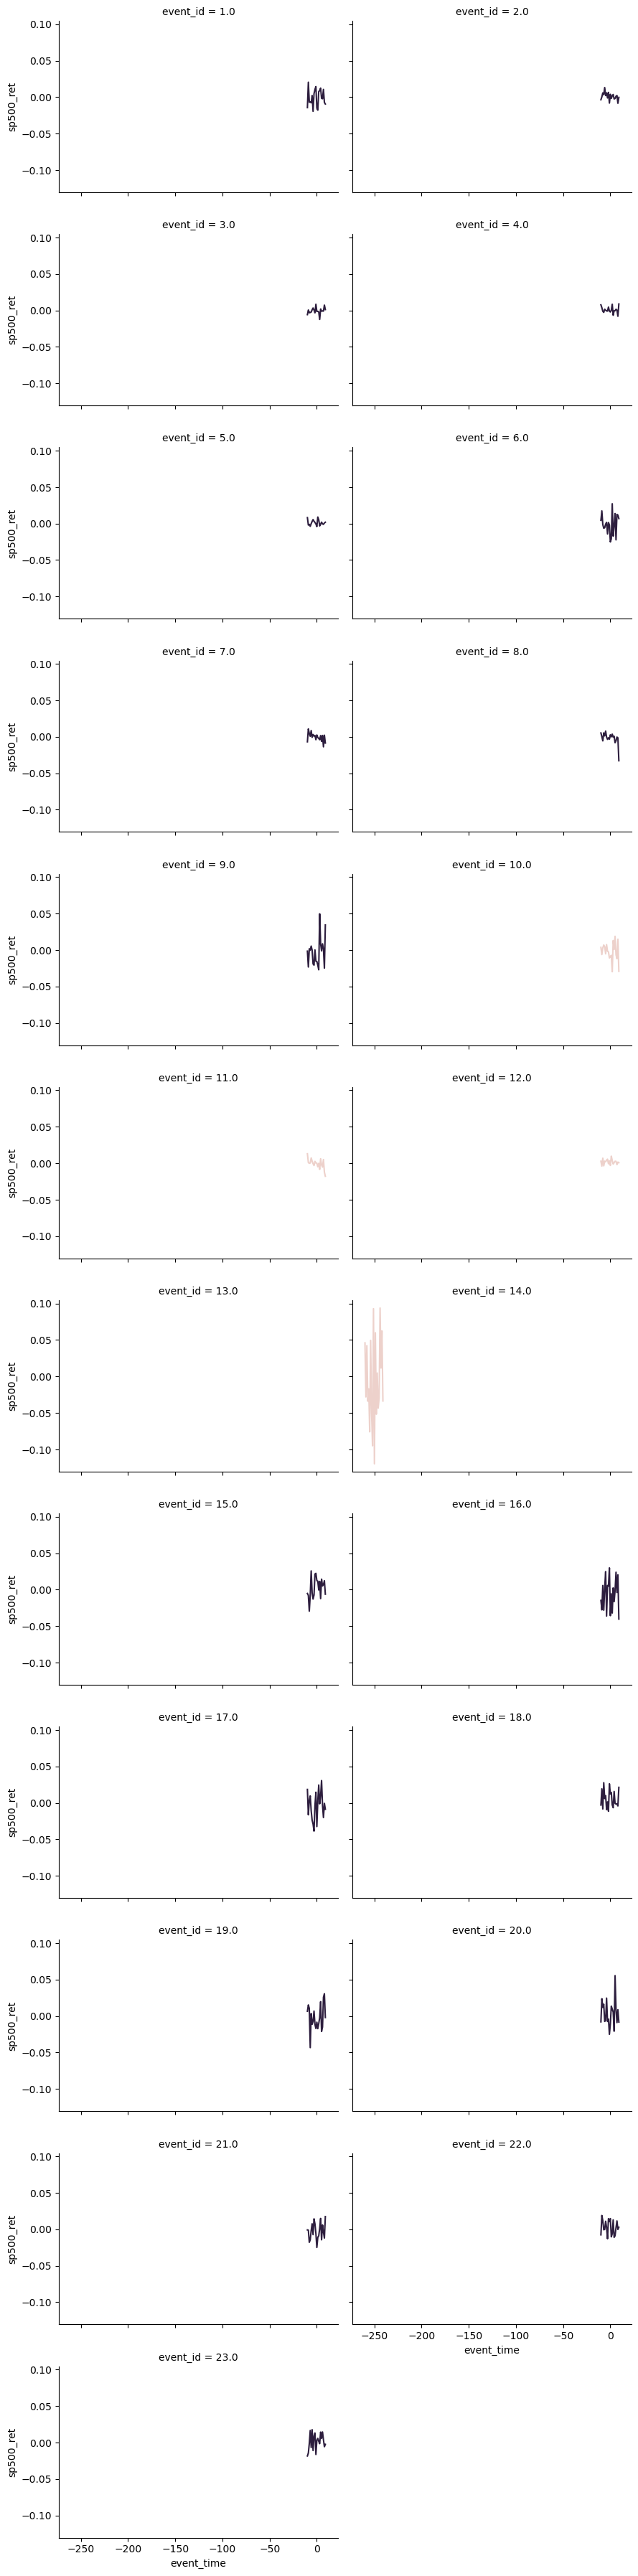

In [23]:
Sp500_graph = sns.relplot(data = event_time_rets,
                x = "event_time",
               y = "sp500_ret",
                    kind = "line",
               col = "event_id",
                    zorder = 5,
                    hue = "Change",
                col_wrap=2, 
                height=3,
                aspect=1.5, 
                legend=False)

### VBILX

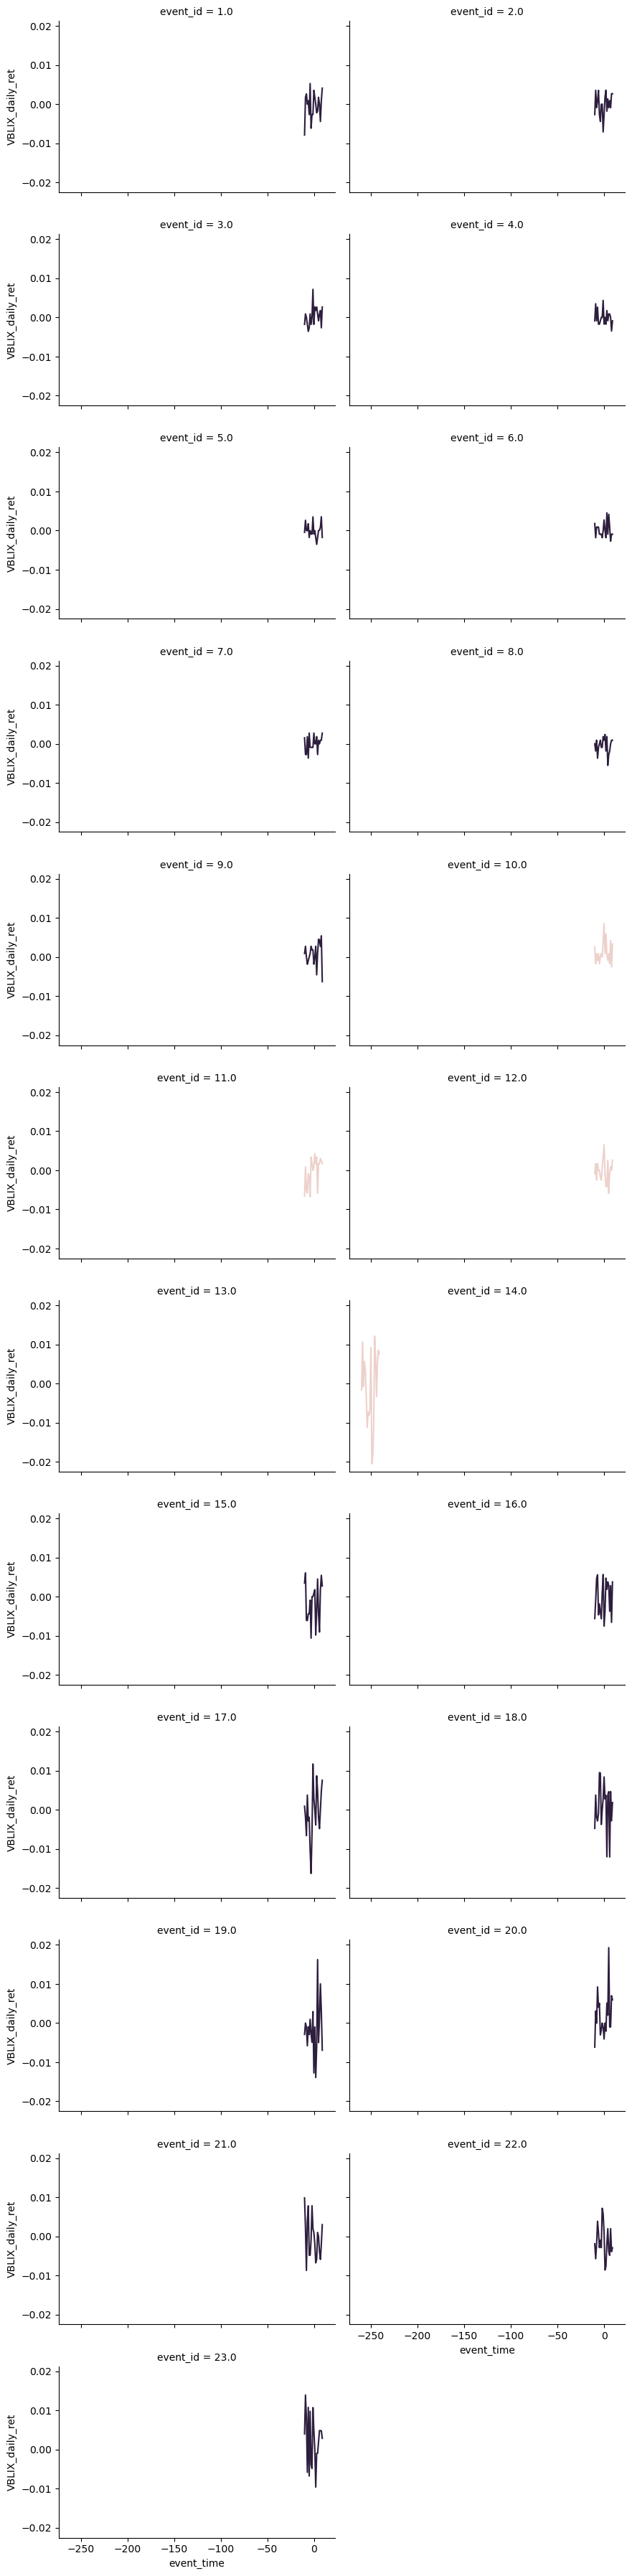

In [24]:
Sp500_graph = sns.relplot(data = event_time_rets,
                x = "event_time",
               y = "VBLIX_daily_ret",
                    kind = "line",
               col = "event_id",
                    zorder = 5,
                    hue = "Change",
                col_wrap=2, 
                height=3,
                aspect=1.5, 
                legend=False)

### VBIRX

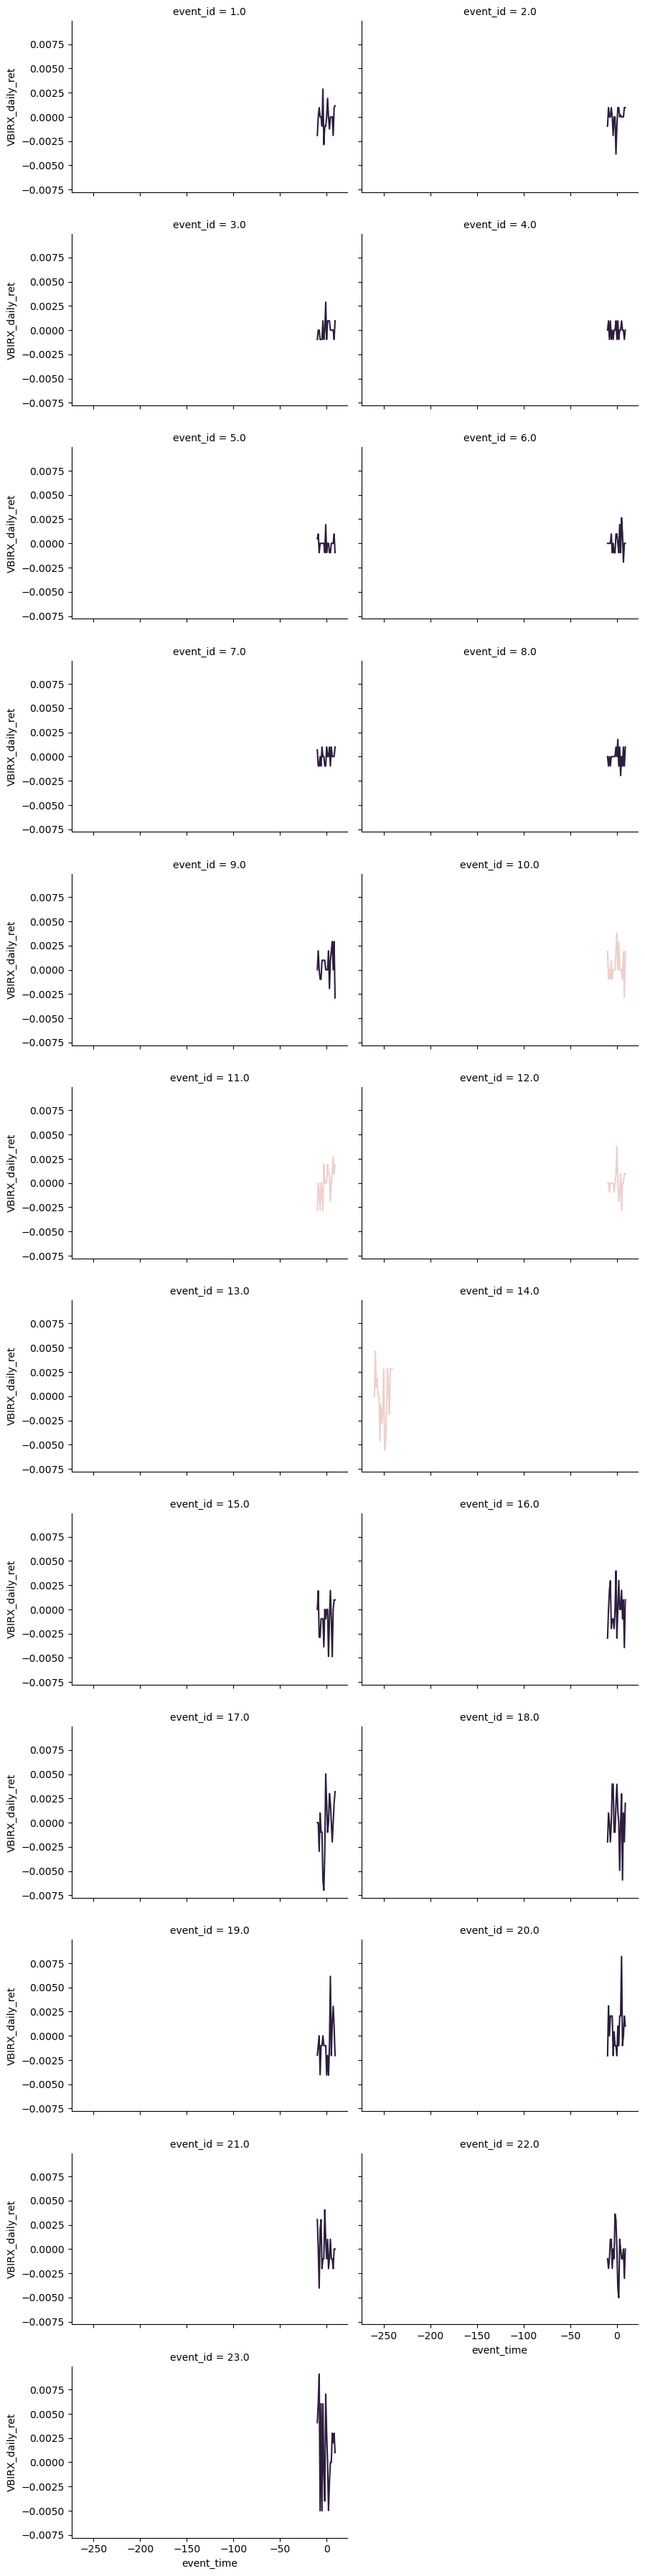

In [25]:
Sp500_graph = sns.relplot(data = event_time_rets,
                x = "event_time",
               y = "VBIRX_daily_ret",
                    kind = "line",
               col = "event_id",
                    zorder = 5,
                    hue = "Change",
                col_wrap=2, 
                height=3,
                aspect=1.5, 
                legend=False)

# Summary Analysis

In [26]:
event_time_rets.head(5)

,Date_x,S&P_500,sp500_ret,VBLIX_daily_ret,VBILX_daily_price,VBIRX_daily_ret,VBIRX_daily_price,event,event_id,event_time,event_id_date,Increase,Decrease,Tgt_level,Change
0,2015-12-03,2049.62,-0.014374,-0.007888,9.178914,-0.001908,9.234923,0,1.0,-10,2015-12-17,25.0,0.0,0.25.0.50,1.0
1,2015-12-04,2091.69,0.020526,0.001767,9.195133,0.000000,9.234923,0,1.0,-9,2015-12-17,25.0,0.0,0.25.0.50,1.0
2,2015-12-07,2077.07,-0.006990,0.002645,9.219457,0.000956,9.243752,0,1.0,-8,2015-12-17,25.0,0.0,0.25.0.50,1.0
3,2015-12-08,2063.59,-0.006490,0.000000,9.219457,0.000000,9.243752,0,1.0,-7,2015-12-17,25.0,0.0,0.25.0.50,1.0
4,2015-12-09,2047.62,-0.007739,0.000880,9.227571,0.000000,9.243752,0,1.0,-6,2015-12-17,25.0,0.0,0.25.0.50,1.0


In [66]:
fomc_rates

,Date,Increase,Decrease,Tgt_level,Change
0,2015-12-17,25.0,0.0,0.25.0.50,1
1,2016-12-15,25.0,0.0,0.50.0.75,1
2,2017-03-16,25.0,0.0,0.75.1.00,1
3,2017-06-15,25.0,0.0,1.00.1.25,1
4,2017-12-14,25.0,0.0,1.25.1.50,1
5,2018-03-22,25.0,0.0,1.50.1.75,1
6,2018-06-14,25.0,0.0,1.75.2.00,1
7,2018-09-27,25.0,0.0,2.00.2.25,1
8,2018-12-20,25.0,0.0,2.25.2.50,1
9,2019-08-01,0.0,25.0,2.00.2.25,0


In [73]:
#Create Dataframe of average SP returns by event
sp_ret_sum = event_time_rets.groupby('event_id_date', as_index=False)['sp500_ret'].mean()
sp_ret_sum.rename(columns = {'sp500_ret': 'sp500_avg_ret'})

,event_id_date,sp500_avg_ret
0,2015-12-17,-0.000797
1,2016-12-15,0.001147
2,2017-03-16,-0.000723
3,2017-06-15,0.000605
4,2017-12-14,0.001164
5,2018-03-22,-0.001093
6,2018-06-14,-0.000434
7,2018-09-27,-0.001785
8,2018-12-20,-0.003030
9,2019-08-01,-0.002390


<AxesSubplot:xlabel='event_id_date', ylabel='sp500_ret'>

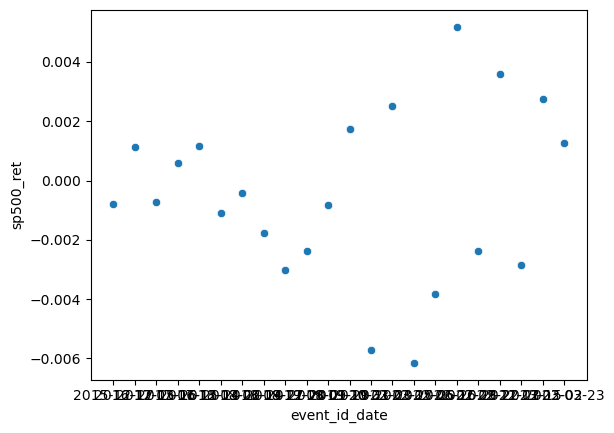

In [60]:
sns.scatterplot(x="event_id_date", 
              y="sp500_ret", 
              data=sp_ret_sum)

In [78]:
sp_VBIRX_sum = event_time_rets.groupby('event_id_date', as_index=False)['VBIRX_daily_ret'].mean()
sp_VBIRX_sum.rename(columns = {'VBIRX_daily_ret': 'VBIRX_avg_ret'})

,event_id_date,VBIRX_avg_ret
0,2015-12-17,-1.472036e-04
1,2016-12-15,-8.559309e-05
2,2017-03-16,4.842886e-05
3,2017-06-15,-4.749421e-05
4,2017-12-14,-7.197094e-05
5,2018-03-22,8.341170e-05
6,2018-06-14,-1.436336e-05
7,2018-09-27,-5.830212e-05
8,2018-12-20,4.878438e-04
9,2019-08-01,4.275745e-04


In [77]:
sns.scatterplot(x="event_id_date", 
              y="VBIRX_avg_ret", 
              data=sp_VBIRX_sum)

ValueError: Could not interpret value `VBIRX_avg_ret` for parameter `y`

In [80]:
sp_VBLIX_sum = event_time_rets.groupby('event_id_date', as_index=False)['VBLIX_daily_ret'].mean()
sp_VBLIX_sum.rename(columns = {'VBLIX_daily_ret': 'VBLIX_avg_ret'})
sp_VBLIX_sum.head(5)

,event_id_date,VBLIX_daily_ret
0,2015-12-17,-0.000386
1,2016-12-15,-0.000150
2,2017-03-16,0.000269
3,2017-06-15,-0.000042
4,2017-12-14,-0.000060


In [83]:
sp_VBLIX_sum.rename(columns = {'VBLIX_daily_ret': 'VBLIX_avg_ret'})
sp_VBLIX_sum

,event_id_date,VBLIX_daily_ret
0,2015-12-17,-0.000386
1,2016-12-15,-0.000150
2,2017-03-16,0.000269
3,2017-06-15,-0.000042
4,2017-12-14,-0.000060
5,2018-03-22,0.000165
6,2018-06-14,0.000034
7,2018-09-27,-0.000477
8,2018-12-20,0.000816
9,2019-08-01,0.001226


In [82]:
sns.scatterplot(x="event_id_date", 
              y="VBIRX_avg_ret", 
              data=sp_VBIRX_sum)

ValueError: Could not interpret value `VBIRX_avg_ret` for parameter `y`